In [1]:
import sqlite3
import pandas as pd
import folium
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten

from scripts import write_weather_data
from utils import weather

conn = sqlite3.connect(r'locations.db')
df_weather = pd.read_sql_query("SELECT Weather.id, min_temp, max_temp, mean_temp, City.city_id, timestamp, name, \
                               City.country_id, City.lat,City.lon, City.altitude \
                               FROM Weather JOIN City ON (Weather.city_id=City.city_id)", conn)
df_city = pd.read_sql_query("Select City.name, city_id, lat, lon, altitude, Country.name as CountryName, Continent.name as ContinentName from City \
                            Join Country ON (City.country_id=Country.id) \
                            JOIN Continent ON (Country.continent_id=Continent.id)"
                            , conn)

In [2]:
df_city.columns

Index(['name', 'city_id', 'lat', 'lon', 'altitude', 'CountryName',
       'ContinentName'],
      dtype='object')

In [3]:
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

In [4]:
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'Oceania': 'orange',
    'Europe': 'pink',
    'North America': 'green',
    'South America': 'lightred'
}

In [5]:
for city in write_weather_data.city_list:
    target_city = df_city.get(df_city['name']== city)
    icon_color = continent_colors[target_city.ContinentName.iloc[0]]
    folium.Marker(location=[target_city['lat'], target_city['lon']],
                icon=folium.Icon(color=icon_color, icon="info-sign"),
                popup=target_city.name.iloc[0]).add_to(m)
    


In [6]:
m

In [7]:
df_mean_values_cities = df_weather.groupby('name').mean()
df_mean_values_cities

,id,min_temp,max_temp,mean_temp,city_id,country_id,lat,lon,altitude
name,,,,,,,,,
Arizona City,658,1.506667,19.826667,10.666667,5551665,2,32.755890,-111.67096,99
Auckland,598,14.591111,23.353333,18.972222,2193733,19,-36.866670,174.76667,26
Bangkok,418,22.608889,31.517778,27.063333,1609350,47,13.753980,100.50144,2
Beijing,433,-10.202222,3.493333,-3.354444,1816670,69,39.907500,116.39723,63
Bogota,743,8.562222,19.573333,14.067778,3688689,100,4.609700,-74.08180,2620
Bologna,538,2.428889,7.702222,5.065556,3181928,1,44.493810,11.33875,54
Canberra,583,11.788889,26.142222,18.965556,2172517,71,-35.283460,149.12807,609
Cape Town,463,16.804444,27.053333,21.928889,3369157,57,-33.925840,18.42322,7
Caracas,688,23.433333,30.200000,26.816667,3646738,54,10.488010,-66.87919,920


<AxesSubplot:xlabel='name'>

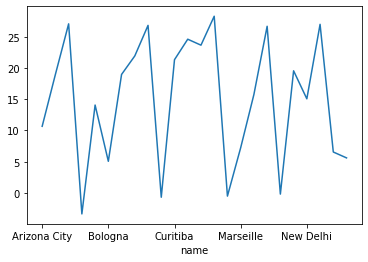

In [8]:
df_mean_values_cities['mean_temp'].plot()

<AxesSubplot:>

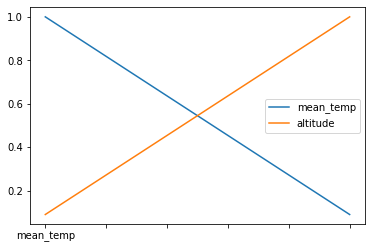

In [10]:
relation_mean_altitude = df_weather[['mean_temp', 'altitude']].corr()
relation_mean_altitude.plot()